# Identifyng Land Use and Land Cover Change Census Block Groups 

- <b>Project Overview</b>

This project aimed at identifying Land Use and Land Cover Change (LULC) locations in St. Louis county in Missouri to serve as one of the inputs into the regional travel demand model. 

- <b>Project Goals</b>

The object of the project was to find the location of land use change between 2012 and 2016 for assessing the impact on transportation and compare land changes to population changes.

- <b>Outcomes</b>

This study used NDVI data from AρρEEARS to achieve project goals. Location of locations of significant change form NDVI data corroborated the population change locations.

- <b>Project Status:</b> 

Completed (December 2018)


In [1]:
#import libraries
from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#Input NDVI Raster Paths
p16="MYD13Q1.006__250m_16_days_NDVI_doy2016361_aid0001.TIF"
p12="MYD13Q1.006__250m_16_days_NDVI_doy2012009_aid0001.TIF"

#Output Files
out16 = 'ndvi2016.tif'
out12 = 'ndvi2012.tif'
out_Change_16_12 = 'ndvi_Change_16_12.tif'

#NDVI Contours
#contours_NDVIChange_19_14 = 'NDVIChange_16_12.shp'

#Open raster bands
b_2016 = gdal.Open(p16)
b_2012 = gdal.Open(p12)

#Read bands as matrix arrays
b2016_Data = b_2016.GetRasterBand(1).ReadAsArray().astype(np.float32)
b2012_Data = b_2012.GetRasterBand(1).ReadAsArray().astype(np.float32)

In [3]:
#compare matrices and geotransformations
print(b_2016.GetProjection()[:80])
print(b_2012.GetProjection()[:80])
if b_2012.GetProjection()[:80]==b_2016.GetProjection()[:80]: print('SRC OK')
    
print(b2012_Data.shape)
print(b2016_Data.shape)
if b2012_Data.shape==b2016_Data.shape: print('Array Size OK')
    
print(b_2016.GetGeoTransform())
print(b_2012.GetGeoTransform())
if b_2012.GetGeoTransform()==b_2016.GetGeoTransform(): print('Geotransformation OK')

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORI
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORI
SRC OK
(242, 298)
(242, 298)
Array Size OK
(-90.73749999156179, 0.002083333333139592, 0.0, 38.891666663049904, 0.0, -0.002083333333139592)
(-90.73749999156179, 0.002083333333139592, 0.0, 38.891666663049904, 0.0, -0.002083333333139592)
Geotransformation OK


In [4]:
#find geotransform parameters
geotransform = b_2012.GetGeoTransform()
originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  b_2012.RasterXSize
rows =  b_2012.RasterYSize

projection = b_2012.GetProjection()

finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

In [5]:
#function to export rasters
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

saveRaster(b2012_Data,out12,cols,rows,projection)

saveRaster(b2016_Data,out16,cols,rows,projection)

In [6]:
#plotting images
extentArray = [originX,finalX,originY,finalY]
def plotNDVI(ndviImage,extentArray,vmin,cmap):
    ndvi = gdal.Open(ndviImage)
    df2016 = ndvi.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(df2016, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Este')
    plt.ylabel('Norte')
    plt.show()

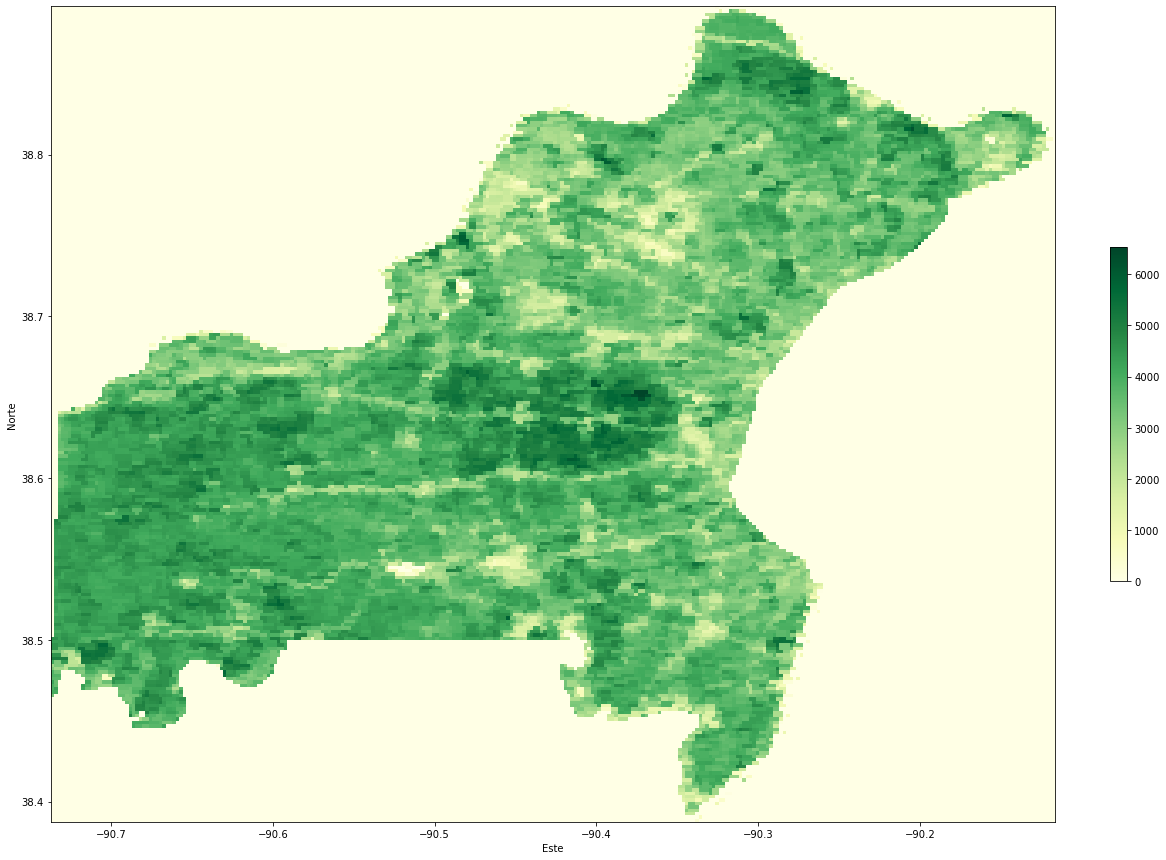

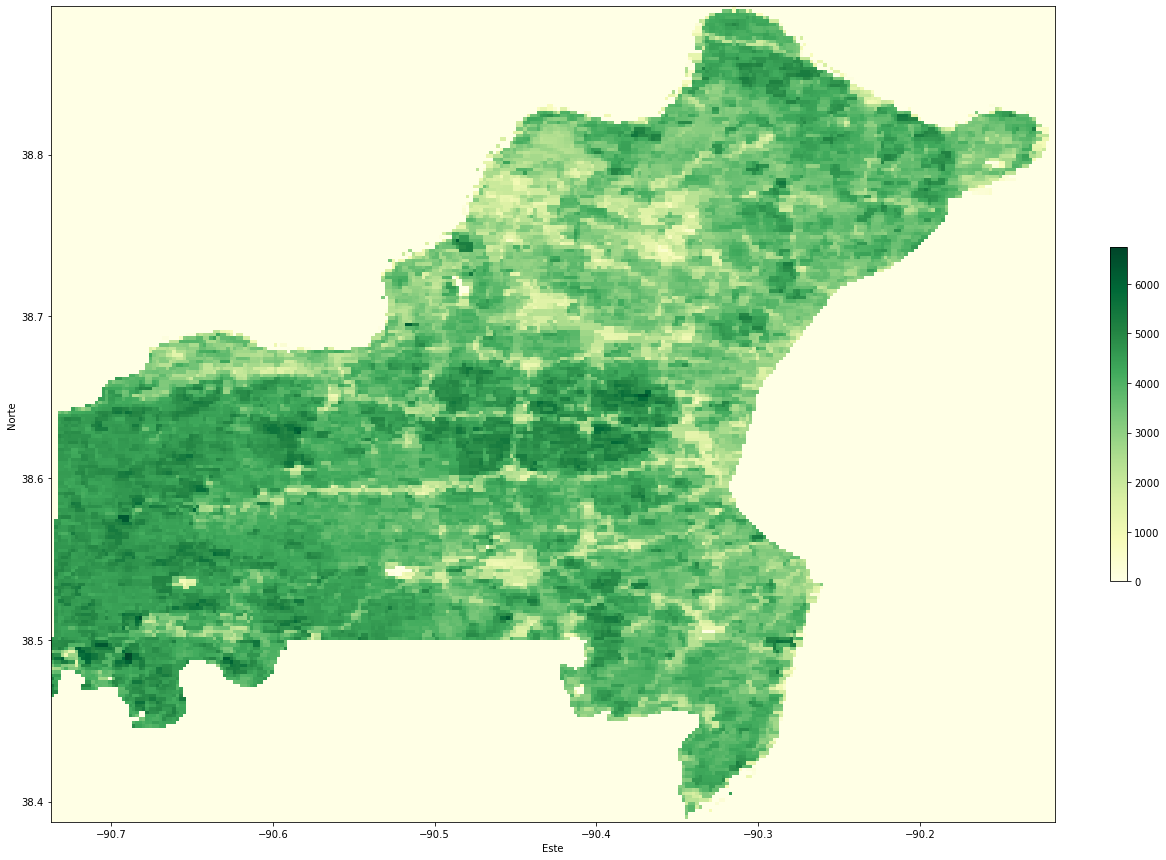

In [7]:
plotNDVI(out12,extentArray,0,'YlGn')
plotNDVI(out16,extentArray,0,'YlGn')

In [8]:
ndviChange = b2016_Data -b2012_Data 
ndviChange = np.where((b2012_Data>-999) & (b2016_Data>-999),ndviChange,-999)

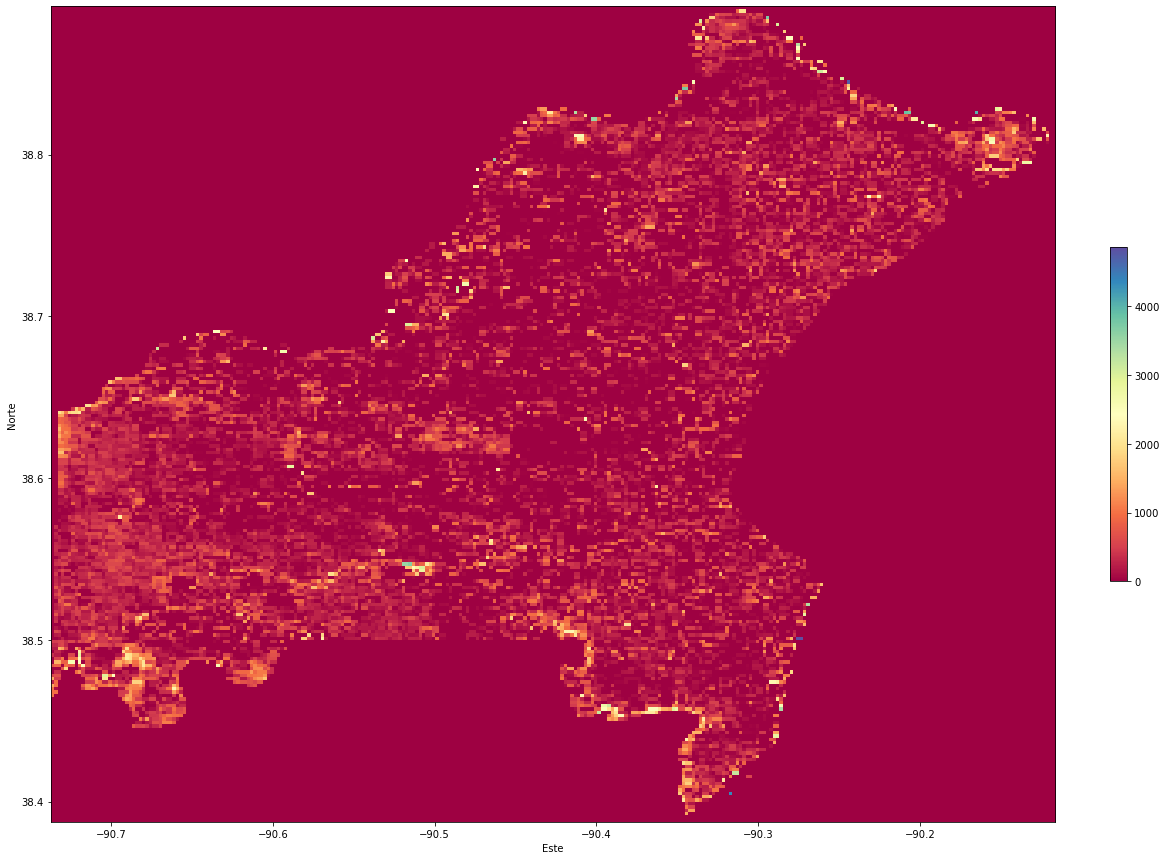

In [9]:
saveRaster(ndviChange,out_Change_16_12,cols,rows,projection)

plotNDVI(out_Change_16_12,extentArray,-.5,'Spectral')

In [10]:
#compare land use image with population and employment changes

In [11]:
#population data for 2012 and 2016
#################################################################
###################################################get pop12 data
import requests, pandas as pd
year='2013'
dsource='acs'
dname='acs5'
cols1='B01001_001E'
state='29'
county='189'

#Base url
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'

#pop
pop= f'{base_url}?get={cols1}&for=block%20group:*&in=state:{state}&in=county:{county}'
pop=requests.get(pop)

#convert to df
pop = pop.json()
pop = pd.DataFrame(pop)
header = pop.iloc[0]
pop = pop[1:]
pop.columns = header

#rename column and create geoid
pop = pop.rename(columns = {'block group': 'bg'})
pop['GEOID']=pop.state+pop.county+pop.tract+pop.bg
pop.drop(columns=['state','county','tract','bg'],inplace=True)

#convert tables into variable
pop=pop.loc[:, ['GEOID','B01001_001E']]
pop=pop.loc[:, ['GEOID','B01001_001E']]
pop13 = pop.rename(columns = {'B01001_001E': 'pop13'})

#################################################################
###################################################get pop16 data
year='2016'
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'
pop= f'{base_url}?get={cols1}&for=block%20group:*&in=state:{state}&in=county:{county}'
pop=requests.get(pop)

#convert to df
pop = pop.json()
pop = pd.DataFrame(pop)
header = pop.iloc[0]
pop = pop[1:]
pop.columns = header

#rename column and create geoid
pop = pop.rename(columns = {'block group': 'bg'})
pop['GEOID']=pop.state+pop.county+pop.tract+pop.bg
pop.drop(columns=['state','county','tract','bg'],inplace=True)

#convert tables into variable
#pop
pop=pop.loc[:, ['GEOID','B01001_001E']]
pop=pop.loc[:, ['GEOID','B01001_001E']]
pop16 = pop.rename(columns = {'B01001_001E': 'pop16'})

##
#get shp
import geopandas as gpd
zipfile = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_29_bg_500k.zip"
dmap = gpd.read_file(zipfile)
dmap=dmap.loc[(dmap['COUNTYFP'] == '189')]
dmap=dmap.loc[:, ['GEOID','geometry']]
dmap.crs = "EPSG:4326"

#join df and shp
pop13['GEOID'] = pop13['GEOID'].astype(str).replace('\.0', '', regex=True)
pop16['GEOID'] = pop16['GEOID'].astype(str).replace('\.0', '', regex=True)

df = [dmap, pop13, pop16]

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['GEOID']), df)
df_merged['geoid'] = df_merged.index.astype(str)

#change column type
df_merged.pop13 = df_merged.pop13.astype(int)
df_merged.pop16 = df_merged.pop16.astype(int)

#calculate percent change
df_merged['perc_change'] = (df_merged['pop16'] - df_merged['pop13']) / df_merged['pop13'] *100
df_merged.head()

,GEOID,geometry,pop13,pop16,geoid,perc_change
0,291892147003,"POLYGON ((-90.37520 38.71817, -90.37477 38.718...",1156,1173,0,1.470588
1,291892198003,"POLYGON ((-90.31296 38.55656, -90.31190 38.562...",993,1228,1,23.665660
2,291892117003,"POLYGON ((-90.29377 38.75349, -90.29360 38.754...",732,1035,2,41.393443
3,291892188002,"POLYGON ((-90.38632 38.60290, -90.38461 38.603...",1424,1535,3,7.794944
4,291892109262,"POLYGON ((-90.33386 38.80069, -90.33093 38.804...",851,934,4,9.753231


In [12]:
import folium
#Population
m = folium.Map(location=[38.628154, -90.416167], zoom_start=10, tiles = 'cartodbpositron')

#bins = list(df_merged["pop"].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(
    geo_data=df_merged,
    data=df_merged,
    key_on='feature.id',
    columns=['geoid','perc_change'],
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.9,
    line_color='white', 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
#    bins=bins,
    legend_name="Population").add_to(m)

m